### Chapter 9: Ordinary differential equations (ODEs)
* DiffEqs: equations where the unknown quantity is a function (not a variable).
* Ordinary DiffEqs: unknown function has only one independent variable w.r.t. to derivatives in the equation.
* Example (1st order ODE): **Newton's Law of Cooling**: dT(t)/dt = -k(T(t)-Ta) == describes body temperature T(t) in surrounding with ambient temperature Ta. Solution is T(t) = Ta+(T0-Ta)*e^-kt.

* Boundary conditions types: *initial value* (IV) & *boundary value* (BV).

# TODO: solve matplotlib  / latex plotting error

In [1]:
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True

In [3]:
import sympy
sympy.init_printing()

In [4]:
from scipy import integrate

### Symbolic ODE solving with SymPy

### Newton's law of cooling

In [5]:
t, k, T0, Ta = sympy.symbols("t, k, T_0, T_a")
T            = sympy.Function("T")

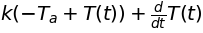

In [6]:
ode = T(t).diff(t) + k*(T(t) - Ta)
ode

In [7]:
# returns symbolic equality object
ode_sol = sympy.dsolve(ode)
ode_sol

In [8]:
# left- and right-hand sides of the equality
ode_sol.lhs, ode_sol.rhs

In [9]:
# define initial condition
ics = {T(0): T0}
ics

In [10]:
# substitute initial condition into solution
# returns equation for unknown integration constant C1.
C_eq = sympy.Eq(
    ode_sol.lhs.subs(t, 0).subs(ics), 
    ode_sol.rhs.subs(t, 0))
C_eq

In [11]:
# apply solver. in this case, only one answer.
C_sol = sympy.solve(C_eq)
C_sol

In [12]:
# sub 1st answer into general ODE for final solution
# corresponding to given initial condition
ode_sol.subs(C_sol[0])

### Function for applying initial conditions

In [13]:
def apply_ics(sol, ics, x, known_params):
    """
    Apply the initial conditions (ics), given as a dictionary on
    the form ics = {y(0): y0: y(x).diff(x).subs(x, 0): yp0, ...}
    to the solution of the ODE with indepdendent variable x.
    The undetermined integration constants C1, C2, ... are extracted
    from the free symbols of the ODE solution, excluding symbols in
    the known_params list.
    """
    free_params = sol.free_symbols - set(known_params)
    eqs = [(sol.lhs.diff(x, n) - sol.rhs.diff(x, n)).subs(x, 0).subs(ics)
           for n in range(len(ics))]
    sol_params = sympy.solve(eqs, free_params)
    return sol.subs(sol_params)

In [14]:
ode_sol

In [15]:
apply_ics(ode_sol, ics, t, [k, Ta])

In [16]:
ode_sol = apply_ics(ode_sol, ics, t, [k, Ta]).simplify()
ode_sol

In [17]:
y_x = sympy.lambdify(
    (t, k), 
    ode_sol.rhs.subs({T0: 5, Ta: 1}), 
    'numpy')

### Damped harmonic oscillator
* example of 2nd-order ODE
* x(t) = oscillator position at time=t
* omega0   = undampled frequency
* gamma    = damping ratio

In [18]:
t, omega0 = sympy.symbols("t, omega_0", positive=True)
gamma =     sympy.symbols("gamma",       complex=True)

In [19]:
x = sympy.Function("x")

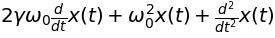

In [20]:
# construct ODE
ode = x(t).diff(t, 2) + 2 * gamma * omega0 * x(t).diff(t) + omega0**2 * x(t)
ode

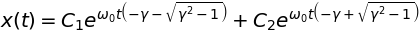

In [21]:
# construct general solution
ode_sol = sympy.dsolve(ode)
ode_sol

In [22]:
# define initial conditions (dict)
ics = {x(0): 1, x(t).diff(t).subs(t, 0): 0}
ics

⎧         ⎛d       ⎞│      ⎫
⎨x(0): 1, ⎜──(x(t))⎟│   : 0⎬
⎩         ⎝dt      ⎠│t=0   ⎭

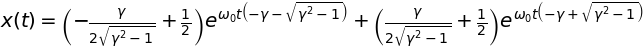

In [23]:
# apply initial conditions to general sol'n
x_t_sol = apply_ics(ode_sol, ics, t, [omega0, gamma])
x_t_sol

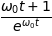

In [24]:
# using gamma=1 (critical damping) ==> divide by zero error
x_t_critical = sympy.limit(x_t_sol.rhs, gamma, 1)
x_t_critical

In [25]:
# plot solutions
'''
fig, ax = plt.subplots(figsize=(8, 4))

tt = np.linspace(0, 3, 250)
for g in [0.1, 0.5, 1, 2.0, 5.0]:
    if g == 1:
        x_t = sympy.lambdify(t, 
                             x_t_critical.subs(
                                 {omega0: 2.0 * sympy.pi}), 'numpy')
    else:
        x_t = sympy.lambdify(t, 
                             x_t_sol.rhs.subs(
                                 {omega0: 2.0 * sympy.pi, gamma: g}), 'numpy')
        
    ax.plot(tt, x_t(tt).real, label=r"$\gamma = %.1f$" % g)

ax.set_xlabel(r"$t$", fontsize=18)
ax.set_ylabel(r"$x(t)$", fontsize=18)
ax.legend()

fig.tight_layout()
fig.savefig('ch9-harmonic-oscillator.pdf')
'''

'\nfig, ax = plt.subplots(figsize=(8, 4))\n\ntt = np.linspace(0, 3, 250)\nfor g in [0.1, 0.5, 1, 2.0, 5.0]:\n    if g == 1:\n        x_t = sympy.lambdify(t, \n                             x_t_critical.subs(\n                                 {omega0: 2.0 * sympy.pi}), \'numpy\')\n    else:\n        x_t = sympy.lambdify(t, \n                             x_t_sol.rhs.subs(\n                                 {omega0: 2.0 * sympy.pi, gamma: g}), \'numpy\')\n        \n    ax.plot(tt, x_t(tt).real, label=r"$\\gamma = %.1f$" % g)\n\nax.set_xlabel(r"$t$", fontsize=18)\nax.set_ylabel(r"$x(t)$", fontsize=18)\nax.legend()\n\nfig.tight_layout()\nfig.savefig(\'ch9-harmonic-oscillator.pdf\')\n'

### Direction field graphs
* How to visualize possible solutions to arbitrary 1st order ODEs
* Built using short lines showing slope of unknown function on x-y grid

In [26]:
def plot_direction_field(x, y_x, f_xy, x_lim=(-5, 5), y_lim=(-5, 5), ax=None):
    
    f_np = sympy.lambdify((x, y_x), f_xy, 'numpy')
    
    x_vec = np.linspace(x_lim[0], x_lim[1], 20)
    y_vec = np.linspace(y_lim[0], y_lim[1], 20)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 4))

    dx = x_vec[1] - x_vec[0]
    dy = y_vec[1] - y_vec[0]

    for m, xx in enumerate(x_vec):
        for n, yy in enumerate(y_vec):
            Dy = f_np(xx, yy) * dx
            Dx = 0.8 * dx**2 / np.sqrt(dx**2 + Dy**2)
            Dy = 0.8 * Dy*dy / np.sqrt(dx**2 + Dy**2)
            ax.plot([xx - Dx/2, xx + Dx/2],
                    [yy - Dy/2, yy + Dy/2], 'b', lw=0.5)
    ax.axis('tight')

    ax.set_title(r"$%s$" %
                 (sympy.latex(sympy.Eq(y(x).diff(x), f_xy))),
                 fontsize=18)
    
    return ax

In [27]:
x = sympy.symbols("x")
y = sympy.Function("y")

In [28]:
#fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#plot_direction_field(x, y(x), y(x)**2 + x, ax=axes[0])
#plot_direction_field(x, y(x), -x / y(x), ax=axes[1])
#plot_direction_field(x, y(x), y(x)**2 / x, ax=axes[2])

#fig.tight_layout()
#fig.savefig('ch9-direction-field.pdf')

![pic](pics/direction-fields.png)

### Inexact solutions to ODEs

In [29]:
x = sympy.symbols("x")
y = sympy.Function("y")

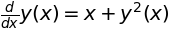

In [30]:
# define the ODE

f = y(x)**2 + x
sympy.Eq(y(x).diff(x), f)

In [31]:
# define initial condition y(0)=0
ics = {y(0): 0}

In [32]:
# define general solution
ode_sol = sympy.dsolve(y(x).diff(x) - f)
ode_sol

In [33]:
# alternative method, using apply_ics
ode_sol = apply_ics(ode_sol, {y(0): 0}, x, [])
ode_sol

In [34]:
# another alternative, directly specifies init condition using ics keyword
ode_sol = sympy.dsolve(y(x).diff(x) - f, ics=ics)
ode_sol

In [35]:
#fig, axes = plt.subplots(1, 2, figsize=(8, 4))

#plot_direction_field(x, y(x), f, ax=axes[0])
#x_vec = np.linspace(-3, 3, 100)
#axes[0].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)
#axes[0].set_ylim(-5, 5)

#plot_direction_field(x, y(x), f, ax=axes[1])
#x_vec = np.linspace(-1, 1, 100)
#axes[1].plot(x_vec, sympy.lambdify(x, ode_sol.rhs.removeO())(x_vec), 'b', lw=2)

#ode_sol_m = ode_sol_p = ode_sol
#dx = 0.125
#for x0 in np.arange(1, 2., dx):
#    x_vec = np.linspace(x0, x0 + dx, 100)
#    ics = {y(x0): ode_sol_p.rhs.removeO().subs(x, x0)}
#    ode_sol_p = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
#    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_p.rhs.removeO())(x_vec), 'r', lw=2)

#for x0 in np.arange(1, 5, dx):
#    x_vec = np.linspace(-x0-dx, -x0, 100)
#    ics = {y(-x0): ode_sol_m.rhs.removeO().subs(x, -x0)}
#    ode_sol_m = sympy.dsolve(y(x).diff(x) - f, ics=ics, n=6)
#    axes[1].plot(x_vec, sympy.lambdify(x, ode_sol_m.rhs.removeO())(x_vec), 'r', lw=2)
    
#fig.tight_layout()
#fig.savefig("ch9-direction-field-and-approx-sol.pdf")

![pic](pics/direction-graphs-2nd-ex.png)

### Laplace transformation method
* alternative to SymPy 'black-box" *dsolve()* method
* technique: laplace-transform the ODE (can be easier to solve) - then use inverse-laplace-transform to to obtain solution to original problem.

In [36]:
t    = sympy.symbols("t", positive=True)
s, Y = sympy.symbols("s, Y", real=True)
y    = sympy.Function("y")

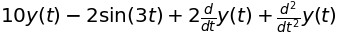

In [37]:
# find ODE for driven harmonic oscillator
ode = y(t).diff(t, 2) + 2 * y(t).diff(t) + 10 * y(t) - 2 * sympy.sin(3*t)
ode

In [38]:
# do transform of unknown qty y(t)
L_y = sympy.laplace_transform(y(t), t, s)
L_y

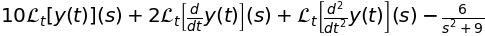

In [39]:
# do transform of entire ODE
L_ode = sympy.laplace_transform(ode, t, s, noconds=True)
L_ode

In [40]:
def laplace_transform_derivatives(e):
    """
    Evaluate the unevaluted laplace transforms of derivatives
    of functions
    """
    if isinstance(e, sympy.LaplaceTransform):
        if isinstance(e.args[0], sympy.Derivative):
            d, t, s = e.args
            n = len(d.args) - 1
            return ((s**n) * sympy.LaplaceTransform(d.args[0], t, s) - 
                    sum([s**(n-i) * sympy.diff(d.args[0], t, i-1).subs(t, 0)
                         for i in range(1, n+1)]))
        
    if isinstance(e, (sympy.Add, sympy.Mul)):
        t = type(e)
        return t(*[laplace_transform_derivatives(arg) for arg in e.args])
    
    return e

In [41]:
L_ode_2 = laplace_transform_derivatives(L_ode)
L_ode_2

 2                                                                            
s ⋅LaplaceTransform(y(t), t, s) + 2⋅s⋅LaplaceTransform(y(t), t, s) - s⋅y(0) + 
                                                                              
                                                                              

                                           ⎛d       ⎞│        6   
10⋅LaplaceTransform(y(t), t, s) - 2⋅y(0) - ⎜──(y(t))⎟│    - ──────
                                           ⎝dt      ⎠│t=0    2    
                                                            s  + 9

In [42]:
L_ode_3 = L_ode_2.subs(L_y, Y)
L_ode_3

   2                                    ⎛d       ⎞│        6   
Y⋅s  + 2⋅Y⋅s + 10⋅Y - s⋅y(0) - 2⋅y(0) - ⎜──(y(t))⎟│    - ──────
                                        ⎝dt      ⎠│t=0    2    
                                                         s  + 9

In [43]:
# now, specify boundary conditions
ics = {y(0): 1, y(t).diff(t).subs(t, 0): 0}
ics

⎧         ⎛d       ⎞│      ⎫
⎨y(0): 1, ⎜──(y(t))⎟│   : 0⎬
⎩         ⎝dt      ⎠│t=0   ⎭

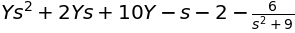

In [44]:
# and sub them back into laplace-transformed ODE
L_ode_4 = L_ode_3.subs(ics)
L_ode_4

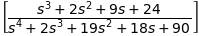

In [45]:
# now, can be solved for Y:
Y_sol = sympy.solve(L_ode_4, Y)
Y_sol

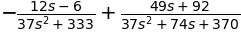

In [46]:
# list of above solutions contains only one element.
sympy.apart(Y_sol[0])

In [47]:
y_sol = sympy.inverse_laplace_transform(Y_sol[0], s, t)

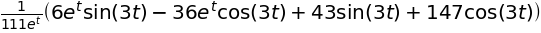

In [48]:
sympy.simplify(y_sol)

In [49]:
y_t = sympy.lambdify(t, y_sol, 'numpy')

In [50]:
#fig, ax = plt.subplots(figsize=(8, 4))

#tt = np.linspace(0, 10, 500)
#ax.plot(tt, y_t(tt).real)
#ax.set_xlabel(r"$t$", fontsize=18)
#ax.set_ylabel(r"$y(t)$", fontsize=18)
#fig.tight_layout()

### Numerical integration of ODEs using SciPy
* Most ODEs can't be solved analytically - use numerical approaches instead
* Multiple approaches - most based on *euler's method*
* Many implementations available - already pkgd into SciPy

* Two ODE solver interfaces: *integrate.odeint()* == simplier; *integrate.ode()* == more flexible

In [51]:
# example: y'(x) = f(x,y(x)) = x+y(x^2)

x = sympy.symbols("x")
y = sympy.Function("y")
f = y(x)**2 + x
f_np = sympy.lambdify((y(x), x), f, 'math')
y0 = 0

In [52]:
# odeint() args:
# right-hand-evaluator-function
# unknown-func-init-conditions
# independent-var-values)

xp = np.linspace(0, 1.9, 100)
yp = integrate.odeint(f_np, y0, xp)
xp.shape, yp.shape

In [53]:
xm = np.linspace(0, -5, 100)
ym = integrate.odeint(f_np, y0, xm)
xm.shape, ym.shape

In [54]:
#fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#plot_direction_field(x, y(x), f, ax=ax)
#ax.plot(xm, ym, 'b', lw=2)
#ax.plot(xp, yp, 'r', lw=2)
#fig.savefig('ch9-odeint-single-eq-example.pdf')

![pic](pics/direction-field-numint.png)

### Lotka-Volterra equations for predator/prey populations
* Use case: vector-valued ODE problems (systems of ODEs)
* Lotka-Volterra equations describe dynamics of coupled ODEs, aka predator-prey systems.

$$
x'(t) = a x - b x y
$$

$$
y'(t) = c x y - d y
$$

In [55]:
a = 0.4   # a = prey birthrate
b = 0.002 # b = predator>prey consumption rate
c = 0.001 # c = predator>prey growth/consumption rate
d = 0.7   # d = predator death rate

In [56]:
# need func for right-hand side of ODE
def f(xy, t):
    x, y = xy
    return [a * x - b * x * y,
            c * x * y - d * y]

In [57]:
# initial conditions: 600 prey animals, 400 predator animals
xy0 = [600, 400]

In [58]:
t = np.linspace(0, 50, 250)

In [59]:
xy_t = integrate.odeint(f, xy0, t)
xy_t.shape

In [60]:
#fig, axes = plt.subplots(1, 2, figsize=(8, 4))

#axes[0].plot(t, xy_t[:,0], 'r', label="Prey")
#axes[0].plot(t, xy_t[:,1], 'b', label="Predator")
#axes[0].set_xlabel("Time")
#axes[0].set_ylabel("Number of animals")
#axes[0].legend()

#axes[1].plot(xy_t[:,0], xy_t[:,1], 'k')
#axes[1].set_xlabel("Number of prey")
#axes[1].set_ylabel("Number of predators")
#fig.tight_layout()
#fig.savefig('ch9-lokta-volterra.pdf')

![pic](pics/predator-prey-populations.png)

### Lorenz equations
* three coupled nonlinear ODEs
* known for chaotic solutions, sensitive to sigma, rho, beta

$$
x'(t) = \sigma(y - x)
$$
$$
y'(t) = x(\rho - z) - y 
$$
$$
z'(t) = x y - \beta z
$$

In [61]:
def f(xyz, t, rho, sigma, beta):
    x, y, z = xyz
    return [sigma * (y - x),
            x * (rho - z) - y,
            x * y - beta * z]

In [62]:
rho, sigma, beta = 28, 8, 8/3.0

In [63]:
t = np.linspace(0, 25, 10000)

In [64]:
xyz0 = [1.0, 1.0, 1.0]

In [65]:
xyz1 = integrate.odeint(f, xyz0, t, args=(rho,   sigma,     beta))
xyz2 = integrate.odeint(f, xyz0, t, args=(rho,   sigma, 0.6*beta))
xyz3 = integrate.odeint(f, xyz0, t, args=(rho, 2*sigma, 0.6*beta))
xyz3.shape

In [66]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [67]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5), subplot_kw={'projection': '3d'})

#for ax, xyz, c in [(ax1, xyz1, 'r'), (ax2, xyz2, 'b'), (ax3, xyz3, 'g')]:
#    ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], c, alpha=0.5)
#    ax.set_xlabel('$x$', fontsize=16)
#    ax.set_ylabel('$y$', fontsize=16)
#    ax.set_zlabel('$z$', fontsize=16)
#    ax.set_xticks([-15, 0, 15])
#    ax.set_yticks([-20, 0, 20])
#    ax.set_zticks([0, 20, 40])

#fig.tight_layout()
#fig.savefig('ch9-lorenz-equations.pdf')

![pic](pics/lorentz-odes.png)

### Coupled damped springs
* 2nd-order, nonlinear ODEs -- for a double pendulum
* equations of motion are for angular deflection of 1st & 2nd pendulums
* 1st pendulum = attached to fixed support
* 2nd pendulum = attached to 1st pendulum
* [scienceworld.com](http://scienceworld.wolfram.com/physics/DoublePendulum.html)

As second-order equations:

\begin{eqnarray}
m_1 x_1''(t) + \gamma_1 x_1'(t) + k_1 (x_1(t) - l_1) - k_2 (x_2(t) - x_1(t) - l_2) &=& 0\\
m_2 x_2''(t) + \gamma_2 x_2' + k_2 (x_2 - x_1 - l_2) &=& 0
\end{eqnarray}

On standard form:

\begin{align}
y_1'(t) &= y_2(t) \\
y_2'(t) &= -\gamma_1/m_1 y_2(t) - k_1/m_1 (y_1(t) - l_1) + k_2 (y_3(t) - y_1(t) - l_2)/m_1 \\
y_3'(t) &= y_4(t) \\
y_4'(t) &= - \gamma_2 y_4(t)/m_2 - k_2 (y_3(t) - y_1(t) - l_2)/m_2 \\
\end{align}

In [68]:
def f(t, y, args):
    m1, k1, g1, m2, k2, g2 = args
    
    return [y[1], 
            - k1/m1 * y[0] + k2/m1 * (y[2] - y[0]) - g1/m1 * y[1], 
            y[3], 
            - k2/m2 * (y[2] - y[0]) - g2/m2 * y[3] ]

In [69]:
# m = mass, l = lengths, g = ?
m1, k1, g1 = 1.0, 10.0, 0.5
m2, k2, g2 = 2.0, 40.0, 0.25

In [70]:
args = (m1, k1, g1, m2, k2, g2)

In [71]:
y0 = [1.0, 0, 0.5, 0]

In [72]:
t = np.linspace(0, 20, 1000)

In [73]:
r = integrate.ode(f)

In [74]:
r.set_integrator('lsoda');
r.set_initial_value(y0, t[0]);
r.set_f_params(args);

In [75]:
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0

while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

In [76]:
#fig = plt.figure(figsize=(10, 4))
#ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
#ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
#ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

#ax1.plot(t, y[:, 0], 'r')
#ax1.set_ylabel('$x_1$', fontsize=18)
#ax1.set_yticks([-1, -.5, 0, .5, 1])

#ax2.plot(t, y[:, 2], 'b')
#ax2.set_xlabel('$t$', fontsize=18)
#ax2.set_ylabel('$x_2$', fontsize=18)
#ax2.set_yticks([-1, -.5, 0, .5, 1])

#ax3.plot(y[:, 0], y[:, 2], 'k')
#ax3.set_xlabel('$x_1$', fontsize=18)
#ax3.set_ylabel('$x_2$', fontsize=18)
#ax3.set_xticks([-1, -.5, 0, .5, 1])
#ax3.set_yticks([-1, -.5, 0, .5, 1])

#fig.tight_layout()
#fig.savefig('ch9-coupled-damped-springs.pdf')

![pic](pics/coupled-damped-oscilators.png)

#### Same calculation as above, but with specifying the Jacobian as well:

In [77]:
def jac(t, y, args):
    m1, k1, g1, m2, k2, g2 = args
    
    return [[0, 1, 0, 0], 
            [- k1/m1 - k2/m1, - g1/m1 * y[1], k2/m1, 0],
            [0, 0, 1, 0],
            [k2/m2, 0, - k2/m2, - g2/m2]]

In [78]:
r = integrate.ode(f, jac).set_f_params(args).set_jac_params(args).set_initial_value(y0, t[0])

In [79]:
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

In [80]:
#fig = plt.figure(figsize=(10, 4))
#ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
#ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
#ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

#ax1.plot(t, y[:, 0], 'r')
#ax1.set_ylabel('$x_1$', fontsize=18)
#ax1.set_yticks([-1, -.5, 0, .5, 1])

#ax2.plot(t, y[:, 2], 'b')
#ax2.set_xlabel('$t$', fontsize=18)
#ax2.set_ylabel('$x_2$', fontsize=18)
#ax2.set_yticks([-1, -.5, 0, .5, 1])

#ax3.plot(y[:, 0], y[:, 2], 'k')
#ax3.set_xlabel('$x_1$', fontsize=18)
#ax3.set_ylabel('$x_2$', fontsize=18)
#ax3.set_xticks([-1, -.5, 0, .5, 1])
#ax3.set_yticks([-1, -.5, 0, .5, 1])

#fig.tight_layout()

### Same calculating, but using SymPy to setup the problem for SciPy

In [81]:
L1 = L2 = 0
t = sympy.symbols("t")
m1, k1, b1 = sympy.symbols("m_1, k_1, b_1")
m2, k2, b2 = sympy.symbols("m_2, k_2, b_2")

In [82]:
x1 = sympy.Function("x_1")
x2 = sympy.Function("x_2")

In [83]:
ode1 = sympy.Eq(m1 * x1(t).diff(t,t,) + b1 * x1(t).diff(t) + k1*(x1(t)-L1) - k2*(x2(t)-x1(t) - L2))

In [84]:
ode2 = sympy.Eq(m2 * x2(t).diff(t,t,) + b2 * x2(t).diff(t) + k2*(x2(t)-x1(t)-L2))

In [85]:
params = {m1: 1.0, k1: 10.0, b1: 0.5,
          m2: 2.0, k2: 40.0, b2: 0.25}

In [86]:
args

In [87]:
y1 = sympy.Function("y_1")
y2 = sympy.Function("y_2")
y3 = sympy.Function("y_3")
y4 = sympy.Function("y_4")

In [88]:
varchange = {x1(t).diff(t, t): y2(t).diff(t), 
             x1(t): y1(t),
             x2(t).diff(t, t): y4(t).diff(t), 
             x2(t): y3(t)}

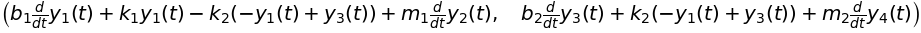

In [89]:
(ode1.subs(varchange).lhs, ode2.subs(varchange).lhs)

In [90]:
ode3 = y1(t).diff(t) - y2(t)

In [91]:
ode4 = y3(t).diff(t) - y4(t)

In [92]:
vcsol = sympy.solve((ode1.subs(varchange), ode2.subs(varchange), ode3, ode4),
                    (y1(t).diff(t), y2(t).diff(t), y3(t).diff(t), y4(t).diff(t)))

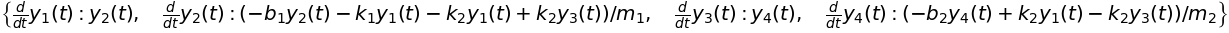

In [93]:
vcsol

In [94]:
ode_rhs = sympy.Matrix([y1(t).diff(t), y2(t).diff(t), y3(t).diff(t), y4(t).diff(t)]).subs(vcsol)

In [95]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])

In [96]:
sympy.Eq(y.diff(t), ode_rhs)

⎡d        ⎤                                               
⎢──(y₁(t))⎥ = ⎡                  y₂(t)                   ⎤
⎢dt       ⎥   ⎢                                          ⎥
⎢         ⎥   ⎢-b₁⋅y₂(t) - k₁⋅y₁(t) - k₂⋅y₁(t) + k₂⋅y₃(t)⎥
⎢d        ⎥   ⎢──────────────────────────────────────────⎥
⎢──(y₂(t))⎥   ⎢                    m₁                    ⎥
⎢dt       ⎥   ⎢                                          ⎥
⎢         ⎥   ⎢                  y₄(t)                   ⎥
⎢d        ⎥   ⎢                                          ⎥
⎢──(y₃(t))⎥   ⎢     -b₂⋅y₄(t) + k₂⋅y₁(t) - k₂⋅y₃(t)      ⎥
⎢dt       ⎥   ⎢     ───────────────────────────────      ⎥
⎢         ⎥   ⎣                    m₂                    ⎦
⎢d        ⎥                                               
⎢──(y₄(t))⎥                                               
⎣dt       ⎦                                               

In [97]:
f_np = sympy.lambdify((t, y), ode_rhs.subs(params), 'numpy')

In [98]:
y0 = [1.0, 0, 0.5, 0]
t = np.linspace(0, 20, 1000)

r = integrate.ode(f_np)
r.set_integrator('lsoda');
r.set_initial_value(y0, t[0]);

dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

In [99]:
#fig = plt.figure(figsize=(10, 4))
#ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
#ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
#ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

#ax1.plot(t, y[:, 0], 'r')
#ax1.set_ylabel('$x_1$', fontsize=18)
#ax1.set_yticks([-1, -.5, 0, .5, 1])

#ax2.plot(t, y[:, 2], 'b')
#ax2.set_xlabel('$t$', fontsize=18)
#ax2.set_ylabel('$x_2$', fontsize=18)
#ax2.set_yticks([-1, -.5, 0, .5, 1])

#ax3.plot(y[:, 0], y[:, 2], 'k')
#ax3.set_xlabel('$x_1$', fontsize=18)
#ax3.set_ylabel('$x_2$', fontsize=18)
#ax3.set_xticks([-1, -.5, 0, .5, 1])
#ax3.set_yticks([-1, -.5, 0, .5, 1])

#fig.tight_layout()

### Double pendulum

http://scienceworld.wolfram.com/physics/DoublePendulum.html

$$
(m_1+m_2) l_1\theta_1'' + m_2l_2\theta_2''\cos(\theta_1-\theta_2)
+ m_2l_2(\theta_2')^2\sin(\theta_1-\theta_2)+g(m_1+m_2)\sin(\theta_1) = 0
$$

$$
m_2l_2\theta_2'' + m_2l_1\theta_1''\cos(\theta_1-\theta_2) - m_2l_1 (\theta_1')^2 \sin(\theta_1-\theta_2)
+m_2g\sin(\theta_2) = 0
$$

In [100]:
t, g, m1, l1, m2, l2 = sympy.symbols("t, g, m_1, l_1, m_2, l_2")

In [101]:
theta1, theta2 = sympy.symbols("theta_1, theta_2", cls=sympy.Function)

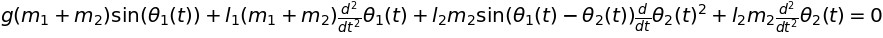

In [102]:
ode1 = sympy.Eq((m1+m2)*l1 * theta1(t).diff(t,t) +
                m2*l2 * theta2(t).diff(t,t) +
                m2*l2 * theta2(t).diff(t)**2 * sympy.sin(theta1(t)-theta2(t)) + 
                g*(m1+m2) * sympy.sin(theta1(t)))
ode1

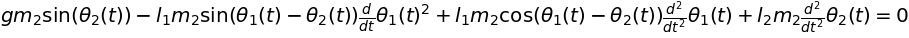

In [103]:
ode2 = sympy.Eq(m2*l2 * theta2(t).diff(t,t) +
                m2*l1 * theta1(t).diff(t,t) * sympy.cos(theta1(t)-theta2(t)) -
                m2*l1 * theta1(t).diff(t)**2 * sympy.sin(theta1(t) - theta2(t)) +
                m2*g * sympy.sin(theta2(t)))
ode2

In [104]:
# this is fruitless, sympy cannot solve these ODEs
try:
    sympy.dsolve(ode1, ode2)
except Exception as e:
    print(e)

cannot determine truth value of Relational


In [105]:
y1, y2, y3, y4 = sympy.symbols("y_1, y_2, y_3, y_4", cls=sympy.Function)

In [106]:
varchange = {theta1(t).diff(t, t): y2(t).diff(t), 
             theta1(t): y1(t),
             theta2(t).diff(t, t): y4(t).diff(t), 
             theta2(t): y3(t)}

In [107]:
ode1_vc = ode1.subs(varchange)

In [108]:
ode2_vc = ode2.subs(varchange)

In [109]:
ode3 = y1(t).diff(t) - y2(t)

In [110]:
ode4 = y3(t).diff(t) - y4(t)

In [111]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])

In [112]:
vcsol = sympy.solve((ode1_vc, ode2_vc, ode3, ode4), y.diff(t), dict=True)

In [113]:
f = y.diff(t).subs(vcsol[0])

In [114]:
sympy.Eq(y.diff(t), f)

⎡d        ⎤                                                                   
⎢──(y₁(t))⎥ = ⎡                                                               
⎢dt       ⎥   ⎢                                                               
⎢         ⎥   ⎢                                                               
⎢d        ⎥   ⎢                                       -g⋅m₁⋅sin(y₁(t)) - g⋅m₂⋅
⎢──(y₂(t))⎥   ⎢                                       ────────────────────────
⎢dt       ⎥   ⎢                                                               
⎢         ⎥   ⎢                                                               
⎢d        ⎥   ⎢                                                               
⎢──(y₃(t))⎥   ⎢                                                               
⎢dt       ⎥   ⎢                                                               
⎢         ⎥   ⎢g⋅m₁⋅sin(2⋅y₁(t) - y₃(t)) - g⋅m₁⋅sin(y₃(t)) + g⋅m₂⋅sin(2⋅y₁(t) 
⎢d        ⎥   ⎢─────────────────────────────────────

In [115]:
params = {m1: 5.0, l1: 2.0,
          m2: 1.0, l2: 1.0, g: 10.0}

In [116]:
f_np = sympy.lambdify((t, y), f.subs(params), 'numpy')

In [117]:
jac = sympy.Matrix([[fj.diff(yi) for yi in y] for fj in f])

In [118]:
jac_np = sympy.lambdify((t, y), jac.subs(params), 'numpy')

In [119]:
y0 = [2.0, 0, 0.0, 0]

In [120]:
t = np.linspace(0, 20, 1000)

In [121]:
jac_np(0, y0)

array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 2.54831741, -0.        ,  0.1767457 , -0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [-5.61099875,  0.        , -2.12094846, -0.        ]])

In [122]:
r = integrate.ode(f_np, jac_np).set_initial_value(y0, t[0]);
 
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

In [123]:
#fig = plt.figure(figsize=(10, 4))
#ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
#ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
#ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

#ax1.plot(t, y[:, 0], 'r')
#ax1.set_ylabel(r'$\theta_1$', fontsize=18)

#ax2.plot(t, y[:, 2], 'b')
#ax2.set_xlabel('$t$', fontsize=18)
#ax2.set_ylabel(r'$\theta_2$', fontsize=18)

#ax3.plot(y[:, 0], y[:, 2], 'k')
#ax3.set_xlabel(r'$\theta_1$', fontsize=18)
#ax3.set_ylabel(r'$\theta_2$', fontsize=18)

#fig.tight_layout()

In [124]:
theta1_np, theta2_np = y[:, 0], y[:, 2]

In [125]:
x1 = params[l1] * np.sin(theta1_np)
y1 = -params[l1] * np.cos(theta1_np)
x2 = x1 + params[l2] * np.sin(theta2_np)
y2 = y1 - params[l2] * np.cos(theta2_np)

In [126]:
#fig = plt.figure(figsize=(10, 4))
#ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
#ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
#ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

#ax1.plot(t, x1, 'r')
#ax1.plot(t, y1, 'b')
#ax1.set_ylabel('$x_1, y_1$', fontsize=18)
#ax1.set_yticks([-3, 0, 3])

#ax2.plot(t, x2, 'r')
#ax2.plot(t, y2, 'b')
#ax2.set_xlabel('$t$', fontsize=18)
#ax2.set_ylabel('$x_2, y_2$', fontsize=18)
#ax2.set_yticks([-3, 0, 3])

#ax3.plot(x1, y1, 'r')
#ax3.plot(x2, y2, 'b', lw=0.5)
#ax3.set_xlabel('$x$', fontsize=18)
#ax3.set_ylabel('$y$', fontsize=18)
#ax3.set_xticks([-3, 0, 3])
#ax3.set_yticks([-3, 0, 3])

#fig.tight_layout()
#fig.savefig('ch9-double-pendulum.pdf')